# Softmax Model with TFIDF Vectorizer 

**Optimizer : NAdam**

### Hyperparameters

- LR = 1e-4 
- Batch Size = 128,
- Epochs = 50

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

Epoch:   0
(Training) - Loss = 1.09643
(Training) - F1 Score = 0.45510
(Validation) - Loss = 1.09282
(Validation) - F1 Score = 0.59510

Epoch:   1
(Training) - Loss = 1.08918
(Training) - F1 Score = 0.64763
(Validation) - Loss = 1.08656
(Validation) - F1 Score = 0.62311

Epoch:   2
(Training) - Loss = 1.08222
(Training) - F1 Score = 0.67886
(Validation) - Loss = 1.08064
(Validation) - F1 Score = 0.62810

Epoch:   3
(Training) - Loss = 1.07546
(Training) - F1 Score = 0.68886


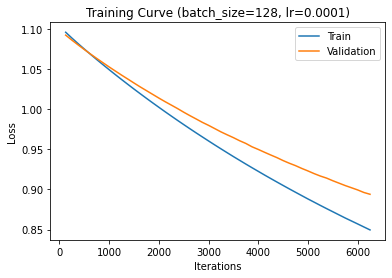

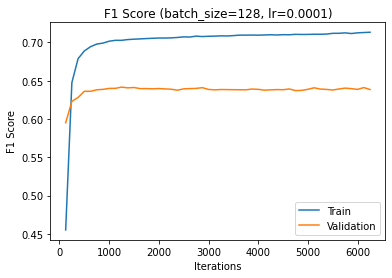

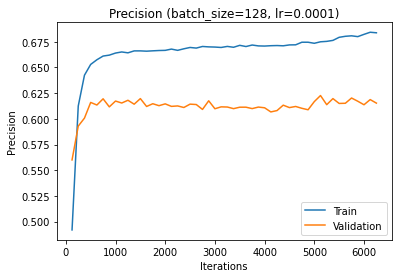

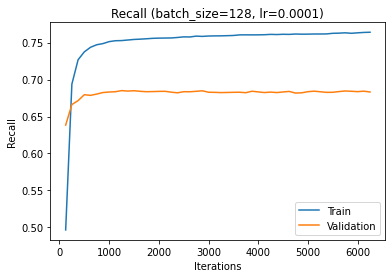

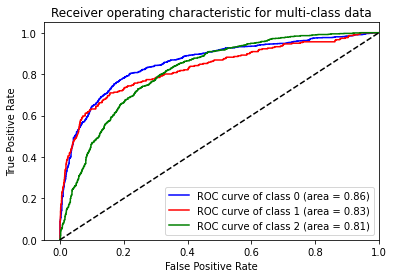

In [30]:
#download glove dataset
!test -f glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound




data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

#Data Preprocessing
set_types = [data_train,data_val]

for set in set_types: 

    set['tweet'] = set['tweet'].dropna() #remove empty cells
    set['tweet'] = set['tweet'].str.replace('[_.!?\\-]', ' ',regex=True)#remove punctuation
    set['tweet'] = set['tweet'].str.replace('[0-9]+', '',regex=True) #remove numbers
    set['tweet'] = set['tweet'].str.lower() #lowercase
    set['tweet'] = set['tweet'].replace('\r\\n', ' ', regex=True)  #remove new line and carriage return
    set['tweet'] = set['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')) #remove emojis
    set['tweet'] = set['tweet'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])#remove links
    set['tweet'] = set['tweet'].replace('\s+', ' ', regex=True) #remove extra whitespaces
    set['tweet'] = set['tweet'].apply(nltk.word_tokenize) #tokenize words
    set['tweet'] = [' '.join(map(str, l)) for l in set['tweet']] #convert words from list to string


### Initialize Vectorizers & Regression
#Define Vectorizers
vectorizer = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 1), stop_words='english', lowercase=True)

y_train = data_train['label']
y_val = data_val['label']

#Create train and validation sets 
x_train = vectorizer.fit_transform(data_train['tweet'])
x_val = vectorizer.transform(data_val['tweet'])


y_train = torch.tensor(y_train,dtype=torch.float)
x_train = torch.tensor(x_train.toarray(),dtype=torch.float)
y_train = y_train.to(torch.long)

y_val = torch.tensor(y_val,dtype=torch.float)
x_val = torch.tensor(x_val.toarray(),dtype=torch.float)
y_val = y_val.to(torch.long)

y_train = nn.functional.one_hot(y_train,num_classes=3)
y_train = y_train.to(torch.float)
y_val = nn.functional.one_hot(y_val,num_classes=3)
y_val = y_val.to(torch.float)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        out =  nn.functional.relu(h1)

        return out


#Define layer sizes
D_in = x_train.shape[1]
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, D_out)
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.8,weight_decay=0.0001)
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
# optimizer = AdaBound(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)

    y_gt = torch.argmax(y_batch,dim=1)
    model_batch_result = torch.argmax(model_batch_result,dim=1)

    # y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_gt,model_batch_result,average='weighted')
    precision = metrics.precision_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)

    y_gt = torch.argmax(y_batch,dim=1)
    model_batch_result = torch.argmax(model_batch_result,dim=1)

    f1Score = metrics.f1_score(y_gt,model_batch_result,average='weighted')
    precision = metrics.precision_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# Default Softmax Vectorized Model

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

Epoch:   0
(Training) - Loss = 1.09117
(Training) - F1 Score = 0.52942
(Validation) - Loss = 1.08299
(Validation) - F1 Score = 0.61335

Epoch:   1
(Training) - Loss = 1.07224
(Training) - F1 Score = 0.64611
(Validation) - Loss = 1.06732
(Validation) - F1 Score = 0.63186

Epoch:   2
(Training) - Loss = 1.05392
(Training) - F1 Score = 0.66645
(Validation) - Loss = 1.05260
(Validation) - F1 Score = 0.63636

Epoch:   3
(Training) - Loss = 1.03636
(Training) - F1 Score = 0.67496


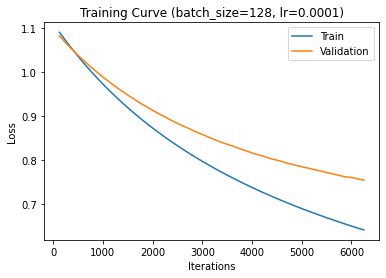

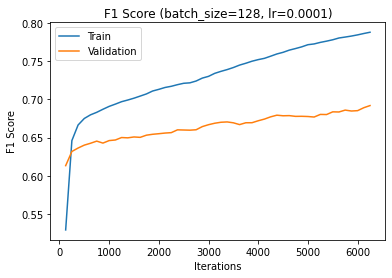

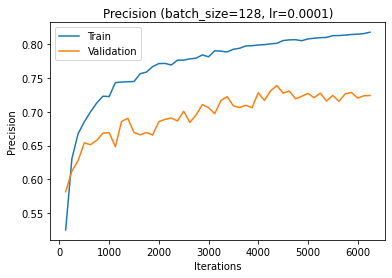

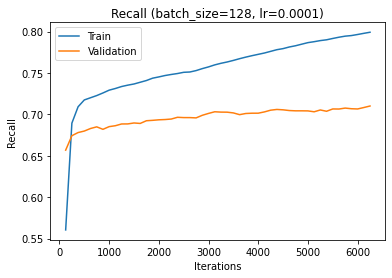

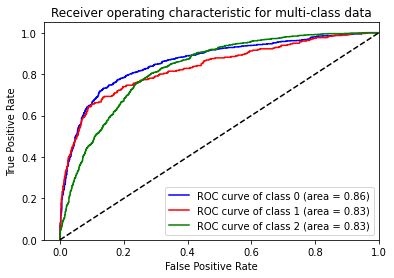

In [31]:
#download glove dataset
!test -f glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound




data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

#Data Preprocessing
set_types = [data_train,data_val]

for set in set_types: 

    set['tweet'] = set['tweet'].dropna() #remove empty cells
    set['tweet'] = set['tweet'].str.replace('[_.!?\\-]', ' ',regex=True)#remove punctuation
    set['tweet'] = set['tweet'].str.replace('[0-9]+', '',regex=True) #remove numbers
    set['tweet'] = set['tweet'].str.lower() #lowercase
    set['tweet'] = set['tweet'].replace('\r\\n', ' ', regex=True)  #remove new line and carriage return
    set['tweet'] = set['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')) #remove emojis
    set['tweet'] = set['tweet'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])#remove links
    set['tweet'] = set['tweet'].replace('\s+', ' ', regex=True) #remove extra whitespaces
    set['tweet'] = set['tweet'].apply(nltk.word_tokenize) #tokenize words
    set['tweet'] = [' '.join(map(str, l)) for l in set['tweet']] #convert words from list to string


### Initialize Vectorizers & Regression
#Define Vectorizers
vectorizer = CountVectorizer(strip_accents='unicode', ngram_range=(1, 1), stop_words='english', lowercase=True)

y_train = data_train['label']
y_val = data_val['label']

#Create train and validation sets 
x_train = vectorizer.fit_transform(data_train['tweet'])
x_val = vectorizer.transform(data_val['tweet'])


y_train = torch.tensor(y_train,dtype=torch.float)
x_train = torch.tensor(x_train.toarray(),dtype=torch.float)
y_train = y_train.to(torch.long)

y_val = torch.tensor(y_val,dtype=torch.float)
x_val = torch.tensor(x_val.toarray(),dtype=torch.float)
y_val = y_val.to(torch.long)

y_train = nn.functional.one_hot(y_train,num_classes=3)
y_train = y_train.to(torch.float)
y_val = nn.functional.one_hot(y_val,num_classes=3)
y_val = y_val.to(torch.float)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        out =  nn.functional.relu(h1)

        return out


#Define layer sizes
D_in = x_train.shape[1]
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, D_out)
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.8,weight_decay=0.0001)
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
# optimizer = AdaBound(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)

    y_gt = torch.argmax(y_batch,dim=1)
    model_batch_result = torch.argmax(model_batch_result,dim=1)

    # y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_gt,model_batch_result,average='weighted')
    precision = metrics.precision_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)

    y_gt = torch.argmax(y_batch,dim=1)
    model_batch_result = torch.argmax(model_batch_result,dim=1)

    f1Score = metrics.f1_score(y_gt,model_batch_result,average='weighted')
    precision = metrics.precision_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()
